In [329]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [331]:
X = pd.read_csv("X_train_NHkHMNU.csv")
y = pd.read_csv("y_train_ZAN5mwg.csv")

# Merge both datasets
df = pd.concat([X, y], axis=1)

# Drop the second-to-last column if needed
df = df.drop(df.columns[-2], axis=1)

# Modèle de base

In [334]:
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

X_all = df.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
y_all = df["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Modèle linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédictions
y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

# Métrique Spearman
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

print("Corrélation (Spearman) train : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Corrélation (Spearman) test  : {:.1f}%".format(100 * spearman_corr(y_test,  y_pred_test)))


Corrélation (Spearman) train : 28.9%
Corrélation (Spearman) test  : 19.5%


# Visualisaton des features

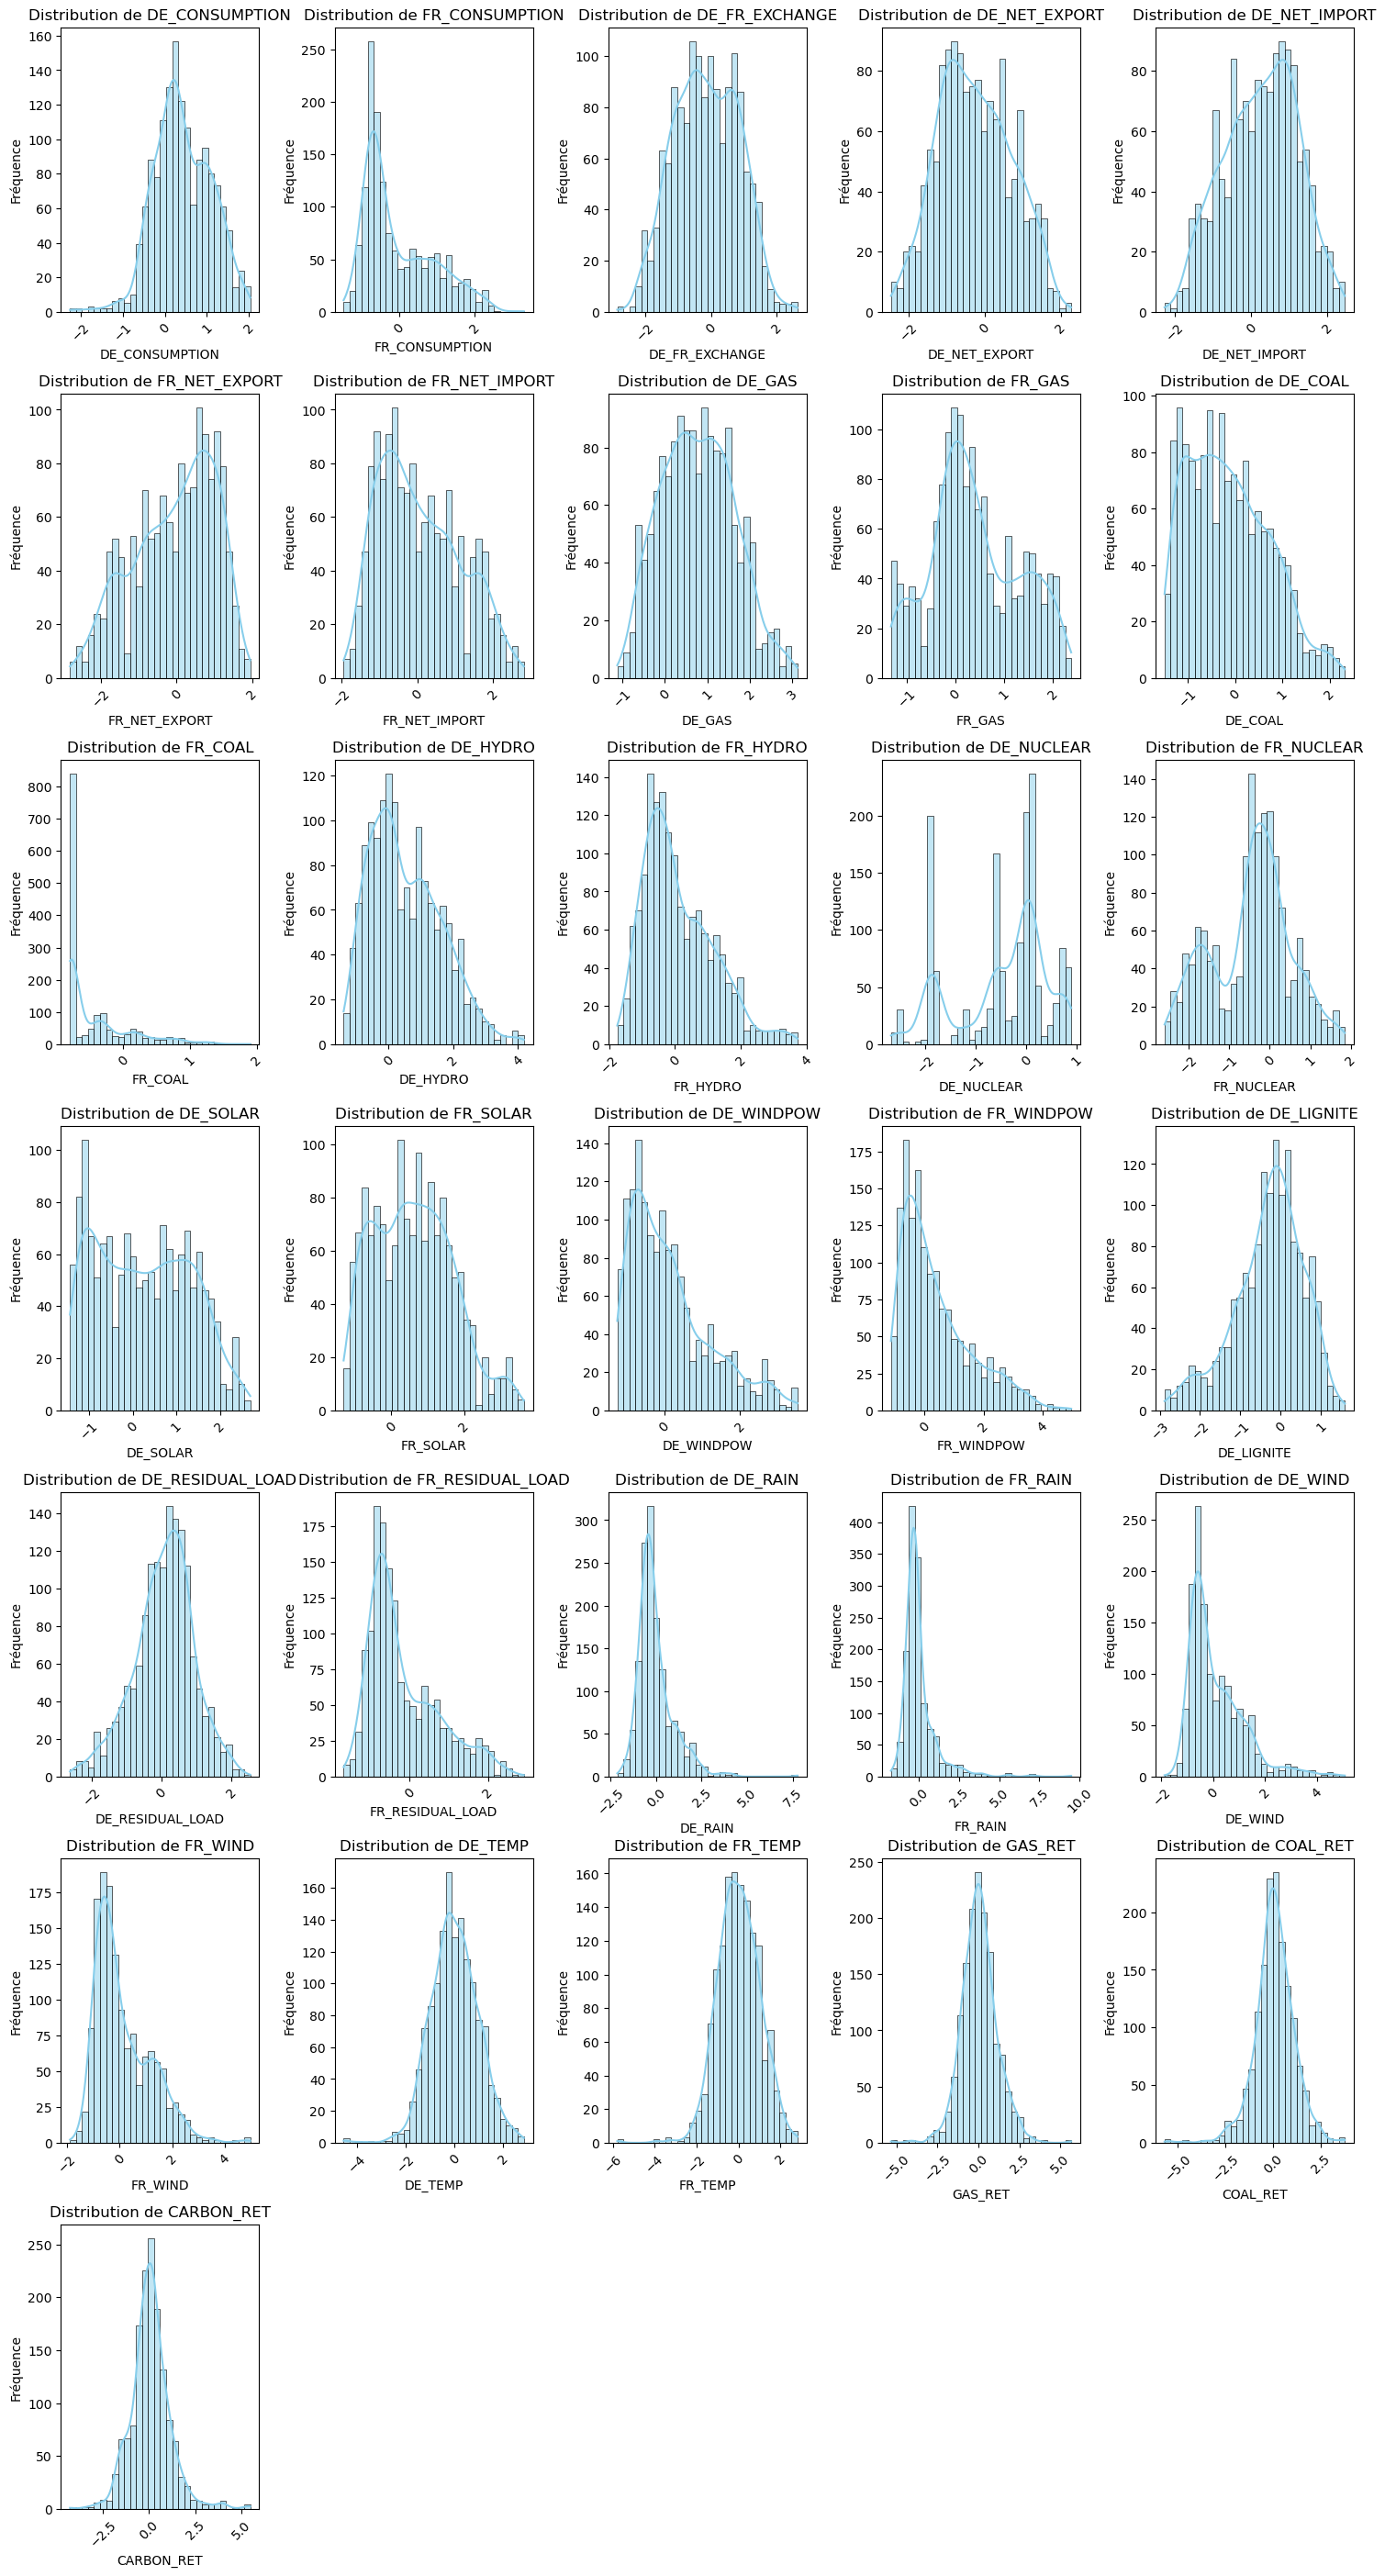

In [337]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_EXPORT', 'DE_NET_IMPORT', 'FR_NET_EXPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO', 
    'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW','DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 
    'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET']

n = len(features)
n_cols = 5  
n_rows = (n // n_cols) + 1  

plt.figure(figsize=(15, 4 * n_rows))

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)  # Crée un sous-graphique
    sns.histplot(df[feature].dropna(), kde=True, color='skyblue', bins=30)  # Histogramme + KDE
    plt.title(f"Distribution de {feature}")
    plt.xlabel(feature)
    plt.ylabel("Fréquence")
    plt.xticks(rotation=45)

plt.tight_layout() 
plt.show()

On peut voir que certaines valeurs ont une fortes assymétrie, notamment avec des queues plus longues à droite, ce qu'on appelle du skew, ceci peut être génant pour des modèles comme des régression linéaires, on va tenter de "normaliser" les variables avec du skew important

# Application de Quantile -> Normal

In [340]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr

# Colonnes à transformer
variables_skew = ['DE_WINDPOW', 'FR_WINDPOW', 'FR_CONSUMPTION', 'DE_COAL', 'FR_RESIDUAL_LOAD', 'FR_WIND', 'FR_HYDRO', 'DE_WIND']

X_all = df.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
y_all = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

qt = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(X_train)), random_state=42)
qt.fit(X_train[variables_skew])

X_train[variables_skew] = qt.transform(X_train[variables_skew])
X_test[variables_skew]  = qt.transform(X_test[variables_skew])

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train_q)
y_pred_test  = lr.predict(X_test_q)

def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

print("Spearman (train) : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Spearman (test)  : {:.1f}%".format(100 * spearman_corr(y_test, y_pred_test)))


Spearman (train) : 30.4%
Spearman (test)  : 19.8%


ça à l'air d'améliorer légèrement les prédictions

# Similaire mais avec création de pipeline

In [343]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr
import joblib

# --- Fonction principale ---
def train_quantile_pipeline(df, variables_skew, test_size=0.2, random_state=42):
    
    X = df.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
    y = df["TARGET"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    preprocessor = ColumnTransformer(transformers=[("quantile", QuantileTransformer(output_distribution='normal',n_quantiles=min(1000, len(X_train)),
                random_state=random_state), variables_skew), ("pass", "passthrough", [c for c in X_train.columns if c not in variables_skew])])

    pipe = Pipeline([ ("preprocessor", preprocessor), ("model", LinearRegression())])

    pipe.fit(X_train, y_train)

    y_pred_train = pipe.predict(X_train)
    y_pred_test  = pipe.predict(X_test)

    metrics = {
        "train": {
            "R2": r2_score(y_train, y_pred_train),
            "MSE": mean_squared_error(y_train, y_pred_train),
            "Spearman": spearman_corr(y_train, y_pred_train)
        },
        "test": {
            "R2": r2_score(y_test, y_pred_test),
            "MSE": mean_squared_error(y_test, y_pred_test),
            "Spearman": spearman_corr(y_test, y_pred_test)
        }
    }

    return pipe, metrics


variables_skew = ['DE_WINDPOW', 'FR_WINDPOW', 'FR_CONSUMPTION',
                  'DE_COAL', 'FR_RESIDUAL_LOAD', 'FR_WIND',
                  'FR_HYDRO', 'DE_WIND']

pipe, metrics = train_quantile_pipeline(df, variables_skew)

print(metrics)


{'train': {'R2': 0.0757943372598312, 'MSE': 0.9595585422662297, 'Spearman': 0.30372588313581117}, 'test': {'R2': -0.007174477203153895, 'MSE': 1.2029415495225775, 'Spearman': 0.19836510524667655}}


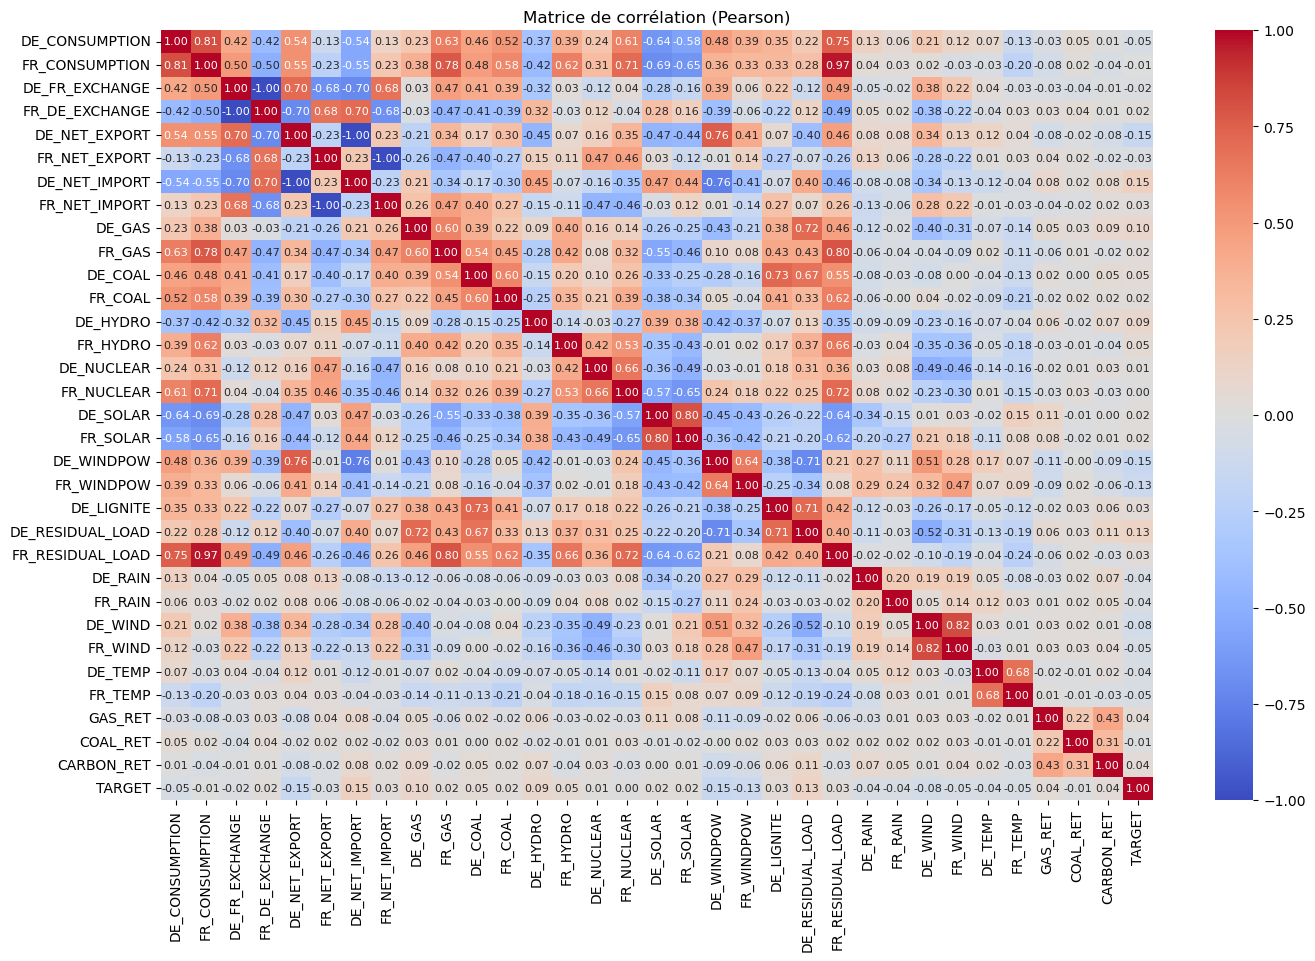

In [344]:
df_continuous = df.drop(columns = ["COUNTRY", "DAY_ID"])

corr_pearson = df_continuous.corr(method='pearson')

# On trace une heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_pearson, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrice de corrélation (Pearson)")
plt.show()

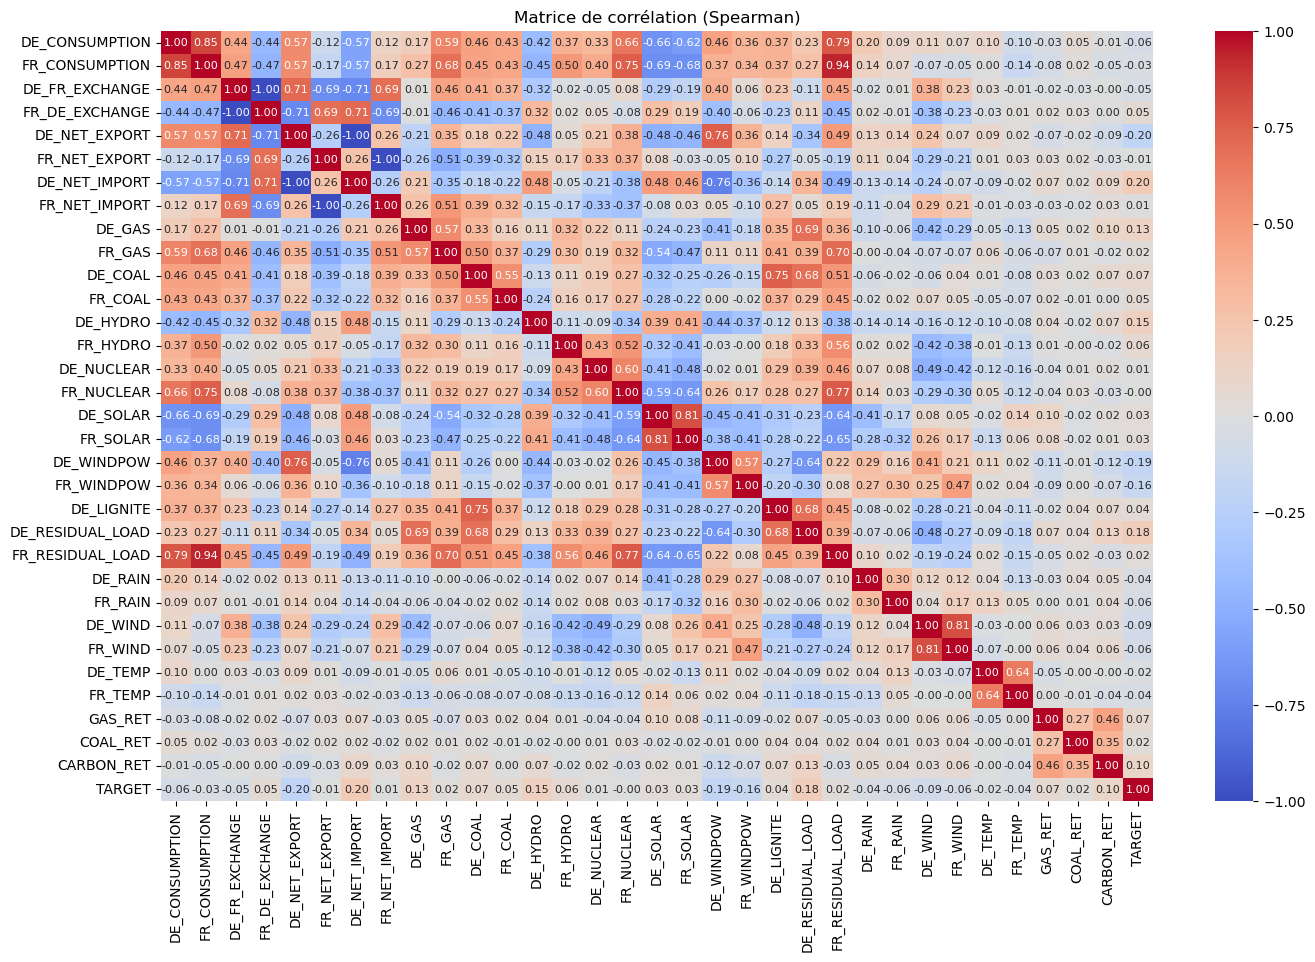

In [345]:
df_continuous = df.drop(columns = ["COUNTRY", "DAY_ID"])

corr_spearman = df_continuous.corr(method='spearman')

# On trace une heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrice de corrélation (Spearman)")
plt.show()

In [346]:
print(f"Valeur absolue moyenne corrélation Pearson featutes/targets: {abs(corr_pearson.iloc[-1].iloc[:-1]).mean()}")
print(f"Valeur absolue moyenne corrélation Spearman featutes/targets: {abs(corr_spearman.iloc[-1].iloc[:-1]).mean()}")

Valeur absolue moyenne corrélation Pearson featutes/targets: 0.053521439875969606
Valeur absolue moyenne corrélation Spearman featutes/targets: 0.07002781106062123


On constate des correlations de spearman en moyenne plus importantes que celles de Pearson, ça s'explique par des relations non linéaires entre features et target.

# Séparation France et Allemagne

Dans les consignes du challenge il est conseillé de modéliser les prix de l'allemagne et de la France différement, ce qui est logique car le prix de l'électricité de l'allemagne n'a aucune raison d'évoluer de la même manière que celui de la france.

In [350]:
df_fr = df[df["COUNTRY"] == "FR"]
df_al = df[df["COUNTRY"] == "DE"]

## Regression Linéaire simple sur chaque dataframe

### France

In [353]:
X_fr = df_fr.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
y_fr = df_fr["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X_fr, y_fr, test_size=0.2, random_state=42)

# Modèle linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédictions
y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

# Métrique Spearman
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

print("Corrélation (Spearman) train : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Corrélation (Spearman) test  : {:.1f}%".format(100 * spearman_corr(y_test,  y_pred_test)))

Corrélation (Spearman) train : 24.5%
Corrélation (Spearman) test  : 3.6%


Très mauvais résultats pour la France

In [355]:
X_de = df_al.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
y_de = df_al["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X_de, y_de, test_size=0.2, random_state=42)

# Modèle linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédictions
y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

# Métrique Spearman
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

print("Corrélation (Spearman) train : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Corrélation (Spearman) test  : {:.1f}%".format(100 * spearman_corr(y_test,  y_pred_test)))

Corrélation (Spearman) train : 44.9%
Corrélation (Spearman) test  : 37.3%


Bien meilleur pour l'Allemagne

In [357]:
variables_skew = ['DE_WINDPOW', 'FR_WINDPOW', 'FR_CONSUMPTION',
                  'DE_COAL', 'FR_RESIDUAL_LOAD', 'FR_WIND',
                  'FR_HYDRO', 'DE_WIND']

pipe, metrics = train_quantile_pipeline(df_fr, variables_skew)

print(metrics)

{'train': {'R2': 0.08135049236384984, 'MSE': 0.8769613720338381, 'Spearman': 0.25751550275249824}, 'test': {'R2': -0.01985780664149739, 'MSE': 1.437947811068443, 'Spearman': 0.09787367573481719}}


In [358]:
variables_skew = ['DE_WINDPOW', 'FR_WINDPOW', 'FR_CONSUMPTION',
                  'DE_COAL', 'FR_RESIDUAL_LOAD', 'FR_WIND',
                  'FR_HYDRO', 'DE_WIND']

pipe, metrics = train_quantile_pipeline(df_al, variables_skew)

print(metrics)

{'train': {'R2': 0.14483148886276587, 'MSE': 0.9663809607344571, 'Spearman': 0.4661603300657243}, 'test': {'R2': 0.011334343267024094, 'MSE': 0.9421372522271948, 'Spearman': 0.3542542486583185}}


On voit qu'en diminuant le skew des features, on améliore les performances pour df_fr mais on baisse pour df_al, cela peut être expliqué par le fait que la plupart des features à fort skew sont des des données française et inluencent donc plus négativement les prédictions des prixs français. Cela montre en tout cas la pertinence de combiner deux modèles différents (un pour chaques nations).

# Sélection des variables pour chacun des modèles.
Il est logique de s'intéresser aux variables vraiment explicatives pour les prix de chaques pays, la météo française n'est pas censé expliqué directement le prix de l'électricité allemande par exemple. On va donc s'intéresser aux corrélations de Spearman spécifiques à chaques pays.

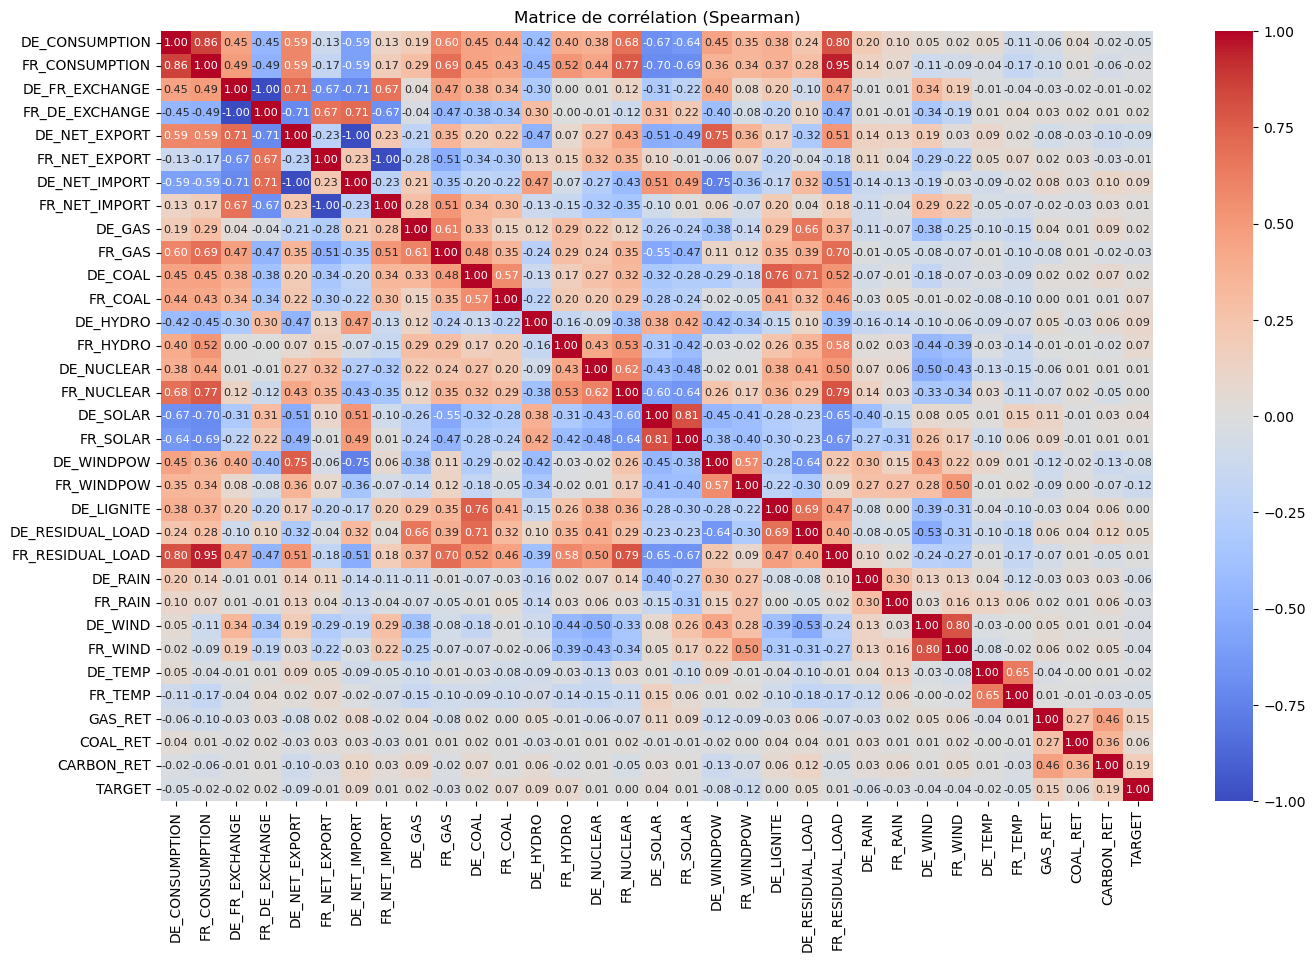

In [361]:
df_continuous_fr = df_fr.drop(columns = ["COUNTRY", "DAY_ID"])

corr_spearman = df_continuous_fr.corr(method='spearman')

# On trace une heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrice de corrélation (Spearman)")
plt.show()

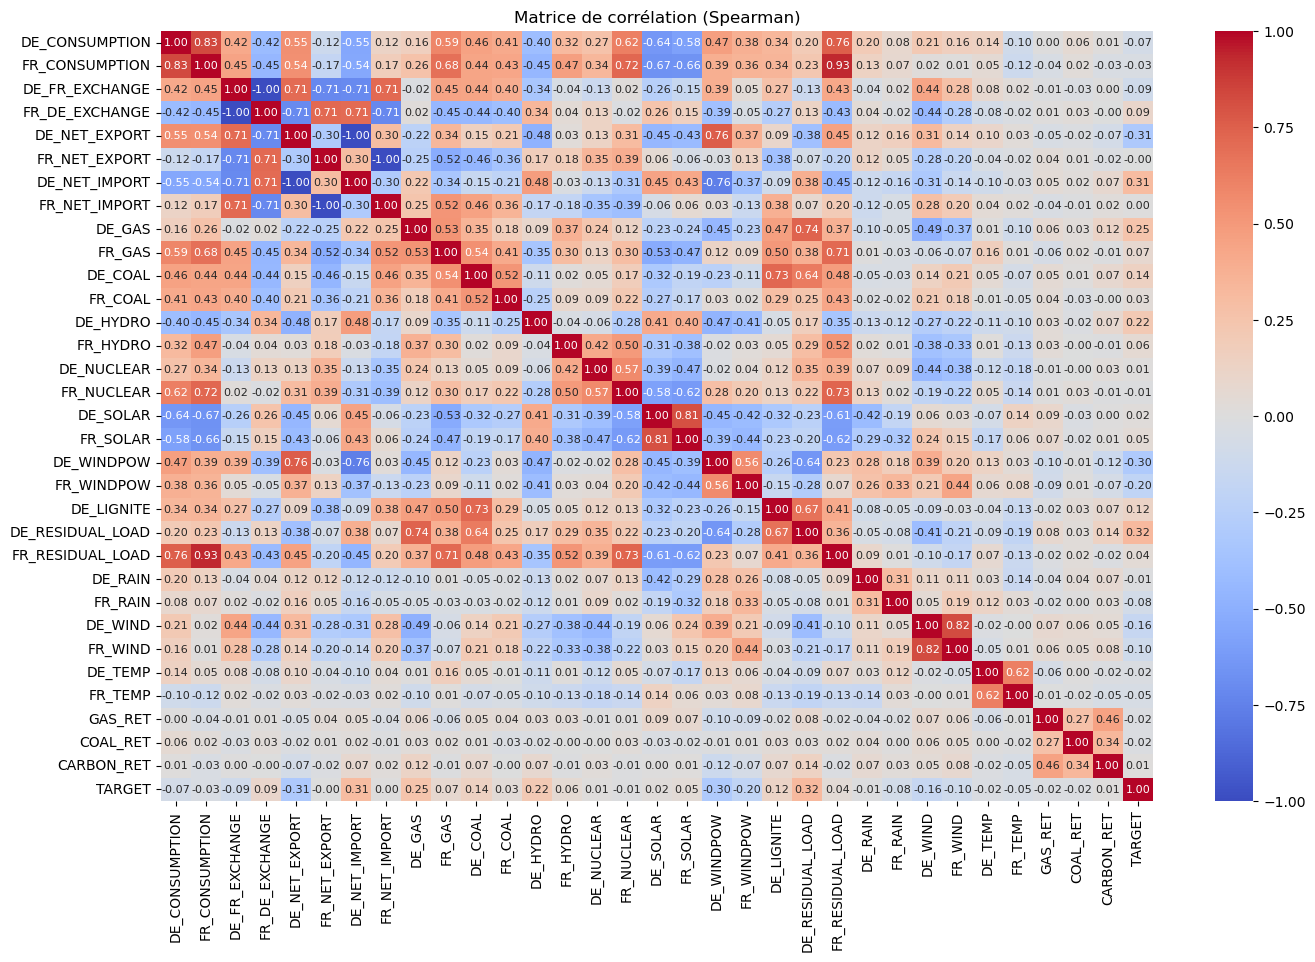

In [362]:
df_continuous_al = df_al.drop(columns = ["COUNTRY", "DAY_ID"])

corr_spearman_al = df_continuous_al.corr(method='spearman')

# On trace une heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman_al, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrice de corrélation (Spearman)")
plt.show()

Ces visualisations expliques clairement la faiblesse de notre modèle vis à vis des prédictions du prix de l'électricité fr, en effet les corrélations de spearman entre les features et Target sont extrèmement faibles, contrairement au df_al où elles sont beaucoup plus importantes. Les corrélations features/target de df_al indiquent qu'il est bien raisonnable d'enlever certaines features liées à la France. On ne va pas enlever toutes les données fr du df_al mais juste utiliser un seuil (qui enlevera majoritaire des données fr mais pas uniquement et pas toutes)

In [364]:
corr_sup =corr_spearman_al.iloc[-1]
coll_keep_al = corr_sup[abs(corr_sup) > 0.08].index
coll_keep_al

Index(['DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'DE_NET_IMPORT',
       'DE_GAS', 'DE_COAL', 'DE_HYDRO', 'DE_WINDPOW', 'FR_WINDPOW',
       'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
       'TARGET'],
      dtype='object')

In [365]:
X_de = df_al[coll_keep_al]
X_de = X_de.drop(columns="TARGET").fillna(0)
y_de = df_al["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X_de, y_de, test_size=0.2, random_state=42)

# Modèle linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédictions
y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

# Métrique Spearman
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

print("Corrélation (Spearman) train : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Corrélation (Spearman) test  : {:.1f}%".format(100 * spearman_corr(y_test,  y_pred_test)))

Corrélation (Spearman) train : 41.4%
Corrélation (Spearman) test  : 38.2%


ça semble améliorer les performance mais reste très sensible au seuil défini (0.08 dans notre cas), fixé assez arbitrairement.

### 1. Structure du mix électrique : France ≠ Allemagne  (ça vient de Chat)

#### France : système très centralisé et pilotable  
La production est majoritairement **nucléaire (environ 65–70 %)**, complétée par de l’**hydraulique** et des **échanges import/export** pilotés.  
La dépendance directe aux fluctuations de vent, de charbon ou de gaz est donc faible pour la production à court terme.  

➡️ Les variables telles que `FR_WINDPOW`, `FR_WIND`, `FR_CONSUMPTION` ou `FR_COAL` influencent faiblement les variations quotidiennes du prix de l’électricité.  

#### Allemagne : système plus exposé aux marchés spot  
Le mix électrique est plus **volatil**, dominé par les **renouvelables intermittents** (éolien, solaire) et le **charbon/gaz**.  
Le **prix de marché** est directement corrélé à ces variations d’offre et de demande.  

➡️ Cela explique des coefficients de **corrélation de Spearman plus élevés** (jusqu’à 0.3–0.4) entre `DE_WINDPOW`, `DE_COAL`, `DE_GAS`, etc., et la variable `TARGET`.  


### 2. Mécanismes de formation du prix  

En **France**, les prix sont souvent influencés par le **couplage des marchés européens**, mais moins directement par les conditions internes :  
> Une baisse du vent en France ne fait pas forcément monter le prix si l’Allemagne exporte massivement à bas coût.  

En **Allemagne**, le **prix spot local** est plus réactif aux **conditions nationales d’offre et de demande** (vent, solaire, charbon, carbone, etc.).  

➡️ En résumé, la **corrélation entre les variables internes et le prix** est **structurellement plus faible en France**.


## IDEES pour expliquer mieux le prix de l'électricité française

1) Utiliser les regimes de fonctionnement (celui du nucleaire par exemple).

<Axes: xlabel='FR_NUCLEAR', ylabel='Count'>

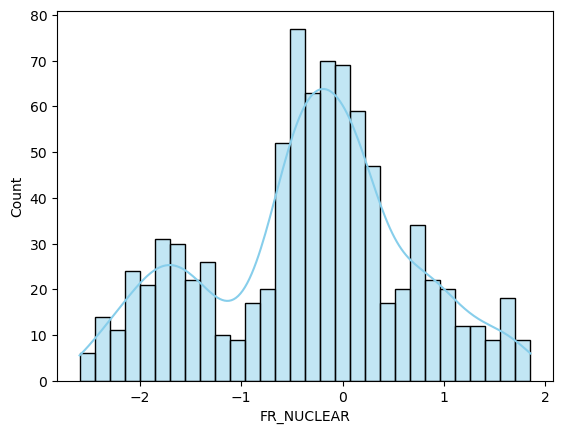

In [370]:
sns.histplot(df_fr["FR_NUCLEAR"].dropna(), kde=True, color='skyblue', bins=30)

On distingue 3 bosses, il serait intéressant de s'intéresser aux différents comportements si l'on se trouve dans le 1er, 2e ou 3e regime. Néanmoins il faut rester générale (et bien penser à faire ju K-fold etc) pour ne pas tomber dans de l'overfitting

In [372]:
# Création d'une colonne REGIME selon les quantiles
quantiles = df_fr["FR_NUCLEAR"].quantile([0.33, 0.66])
q1, q2 = quantiles[0.33], quantiles[0.66]

def classify_regime(x):
    if x <= q1:
        return 0  
    elif x <= q2:
        return 1 
    else:
        return 2  

df_fr["REGIME"] = df_fr["FR_NUCLEAR"].apply(classify_regime)


C:\Users\mathi\AppData\Local\Temp\ipykernel_27684\2207417278.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fr["REGIME"] = df_fr["FR_NUCLEAR"].apply(classify_regime)


In [374]:
df_reg0 = df_fr[df_fr["REGIME"] == 0]
df_reg1 = df_fr[df_fr["REGIME"] == 1]
df_reg2 = df_fr[df_fr["REGIME"] == 2]




### Matrice de corrélations Régime 0

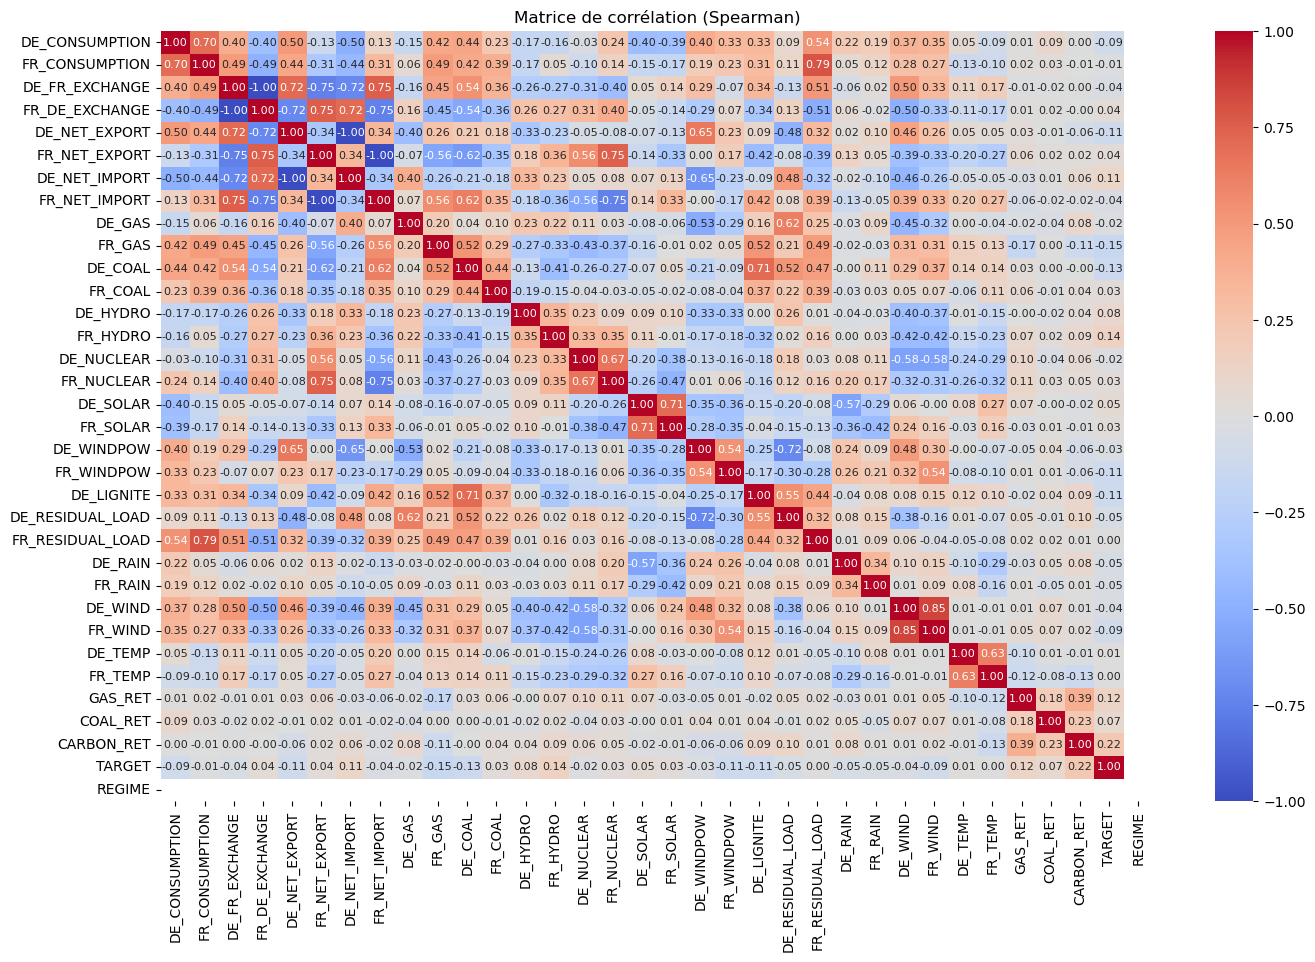

In [377]:
df_continuous_reg0 = df_reg0.drop(columns = ["COUNTRY", "DAY_ID"])

corr_spearman = df_continuous_reg0.corr(method='spearman')

# On trace une heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrice de corrélation (Spearman)")
plt.show()

### Matrice de corrélations Régime 1

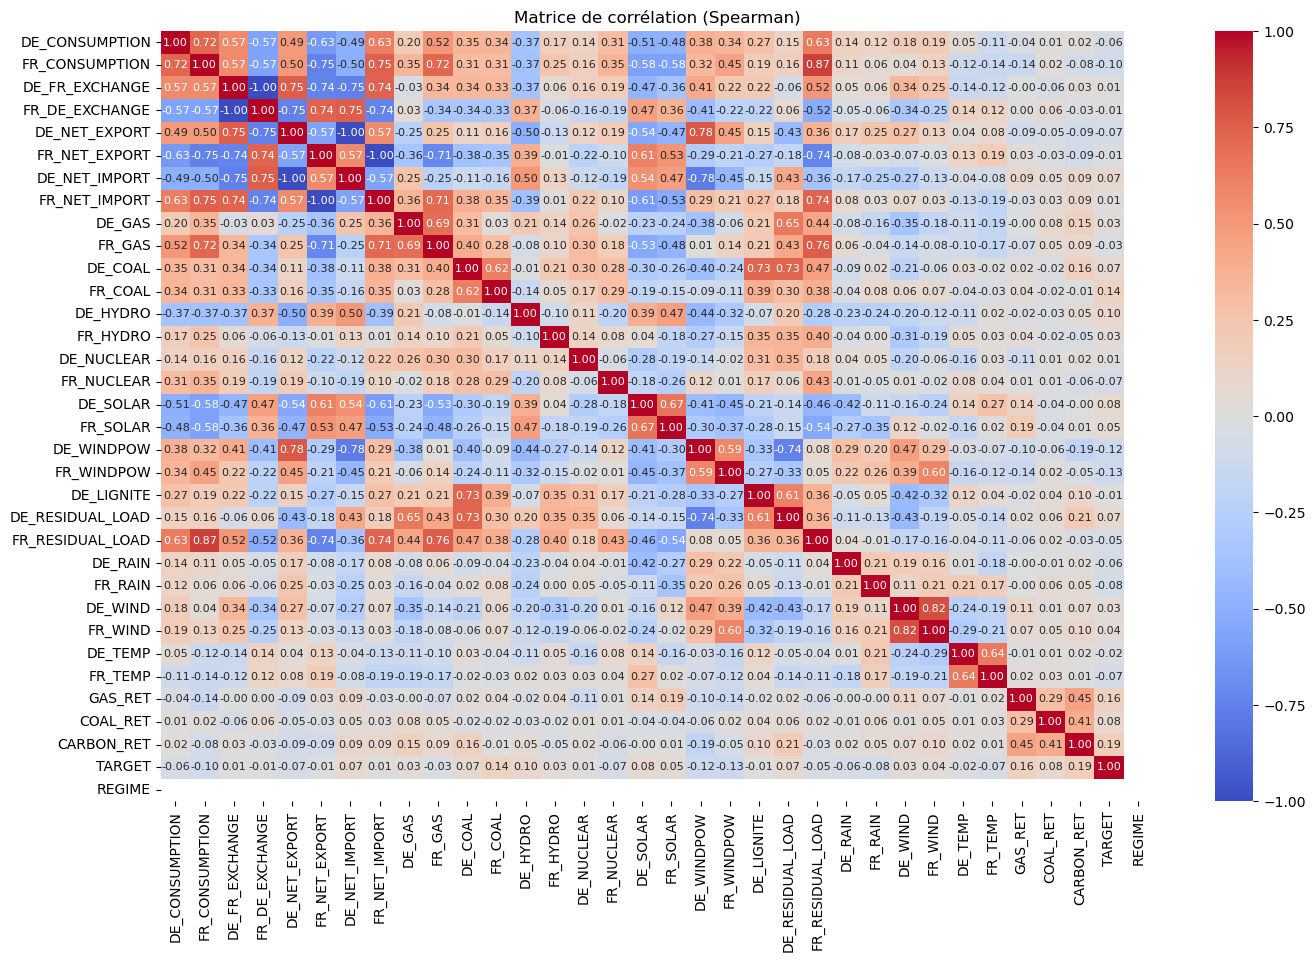

In [380]:
df_continuous_reg1 = df_reg1.drop(columns = ["COUNTRY", "DAY_ID"])

corr_spearman = df_continuous_reg1.corr(method='spearman')

# On trace une heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrice de corrélation (Spearman)")
plt.show()

### Matrice de corrélations Régime 2

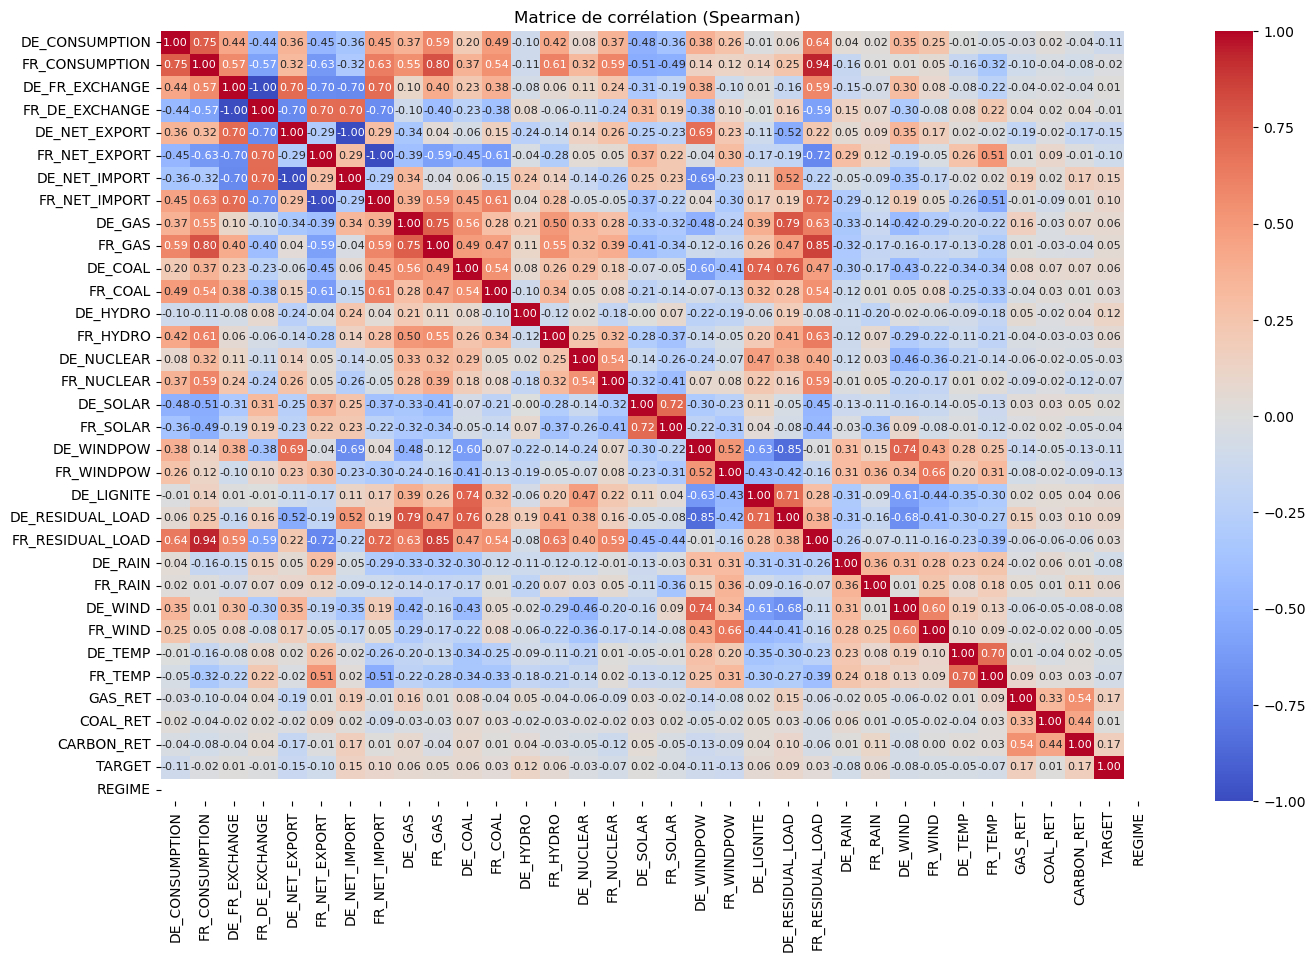

In [382]:
df_continuous_reg2 = df_reg2.drop(columns = ["COUNTRY", "DAY_ID"])

corr_spearman = df_continuous_reg2.corr(method='spearman')

# On trace une heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrice de corrélation (Spearman)")
plt.show()

On voit bien des comportements différents, il faudrait mieux définir les seuils des régimes (c'est pour l'instant des quantiles) et s'assurer que ces comportement sont réels et pas simplement dus aux données